# 精神病に関するアンケート結果の解析

In [4]:
import numpy as np
import pandas as pd
import pandas_profiling
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model as lm
from sklearn.metrics import confusion_matrix
from collections import OrderedDict

## データ概観

In [5]:
df_raw = pd.read_csv('./survey.csv')
pandas_profiling.ProfileReport(df_raw)

Number of variables,27
Number of observations,1259
Total Missing (%),5.6%
Total size in memory,265.6 KiB
Average record size in memory,216.1 B
Numeric,1
Categorical,26
Boolean,0
Date,0
Text (Unique),0
Rejected,0


一見して以下の事がわかる。
- Ageに外れ値がある
- Genderの名寄せが必要
- work_interfere、commentsは無効値が多い
- アメリカ合衆国以外の(stateの記載がない)回答が約40%

## 方針
##### treatment（精神病の治療を受けたことがあるか）を目的変数とする
1. 年齢が外れ値の項目を削除
1. 性別を名寄せ
1. 無効値を"no_data"で置換

In [6]:
df = df_raw.copy()

#### 年齢が異常値（0歳以下、120歳以上）のデータを削除

In [7]:
# 年齢が異常値の行を削除
drop_list = []
for index, row in df.iterrows():
    if int(row['Age']) < 0 or int(row['Age']) > 120:
        drop_list.append(index)
df.drop(drop_list, inplace=True)

#### 性別の名寄せ（男性、女性、その他）

In [8]:
df.loc[df['Gender'].str.lower().str.contains('^(cis)*.*(female|woman|f|femail).?$'), 'Gender'] = 'F'
df.loc[df['Gender'].str.lower().str.contains('^female \(cis\)$'), 'Gender'] = 'F'
df.loc[df['Gender'].str.lower().str.contains('^(cis)*.*(male|man|m|make|mail).?$'), 'Gender'] = 'M'
df.loc[df['Gender'].str.lower().str.contains('^(male \(cis\)|mal)$'), 'Gender'] = 'M'
df.loc[~df['Gender'].str.contains('(^(F|M)$)'),'Gender'] = 'other'

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


#### 無効値を"no_data"で置き換え

In [9]:
df.fillna({'self_employed':'no_data', 'state':'no_data', 'work_interfere':'no_data'}, inplace=True)

#### その他
- 回答日時を年のみに変更
- コメントありの場合、"existence"とする
- アメリカ以外の国の場合は州を"no_data"にする

In [10]:
df.replace('-[0-9]+-[0-9]+ .*', '', regex=True, inplace=True)
df.fillna({'comments':'none'}, inplace=True)
df.loc[df['comments'] != 'none', 'comments'] = 'existence'
df.loc[df['Country'] != 'United States', 'state'] = 'no_data'

## treatment との関係を確認

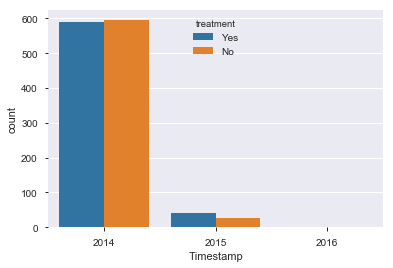

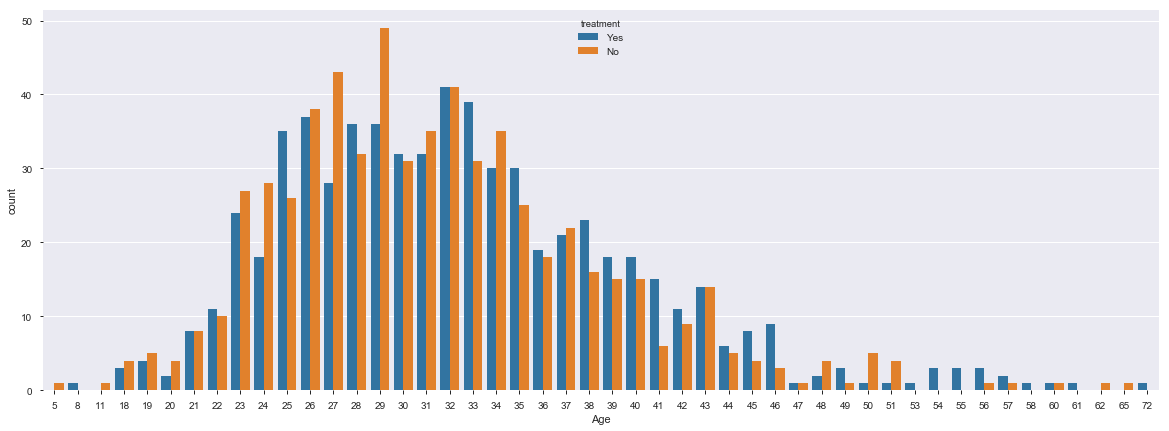

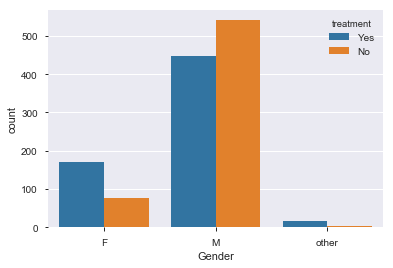

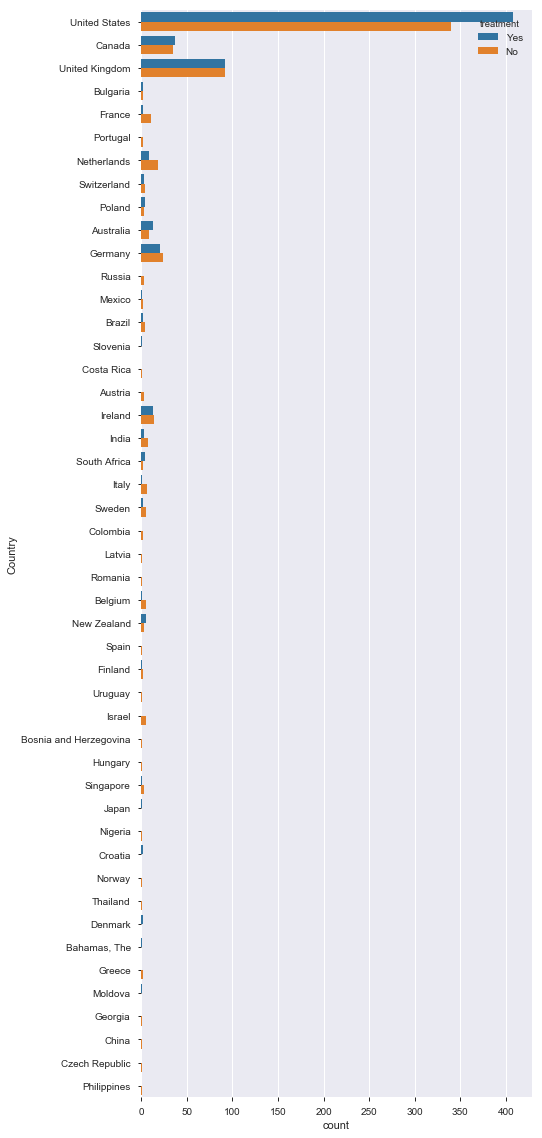

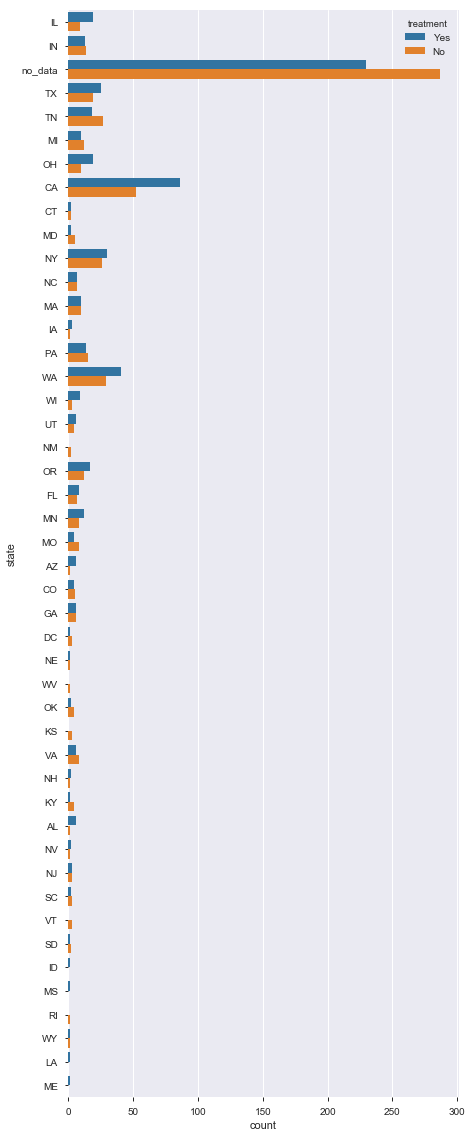

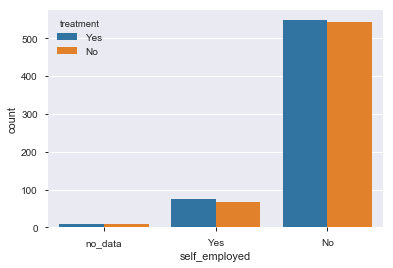

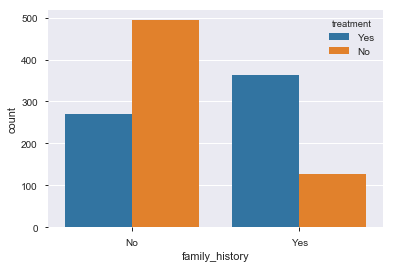

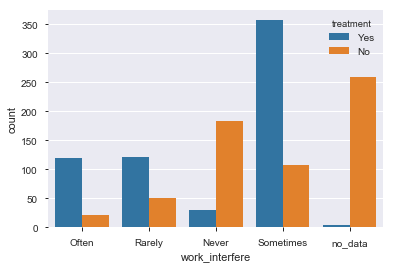

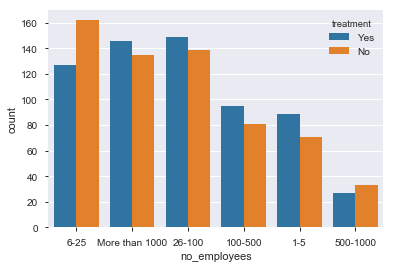

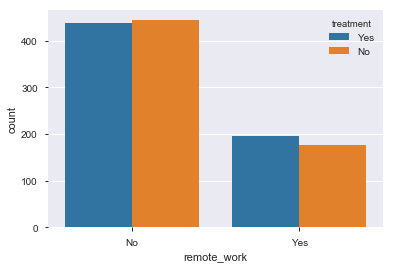

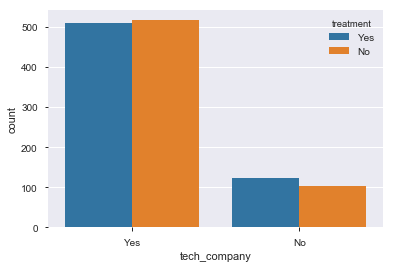

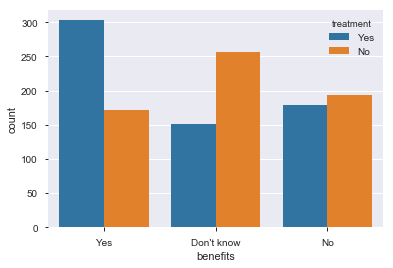

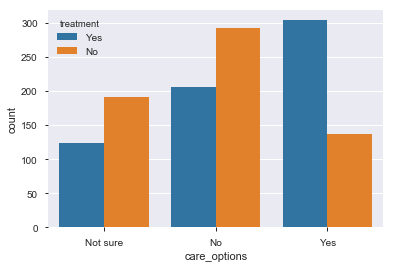

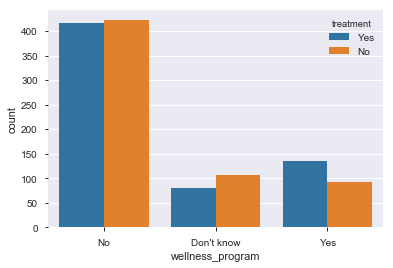

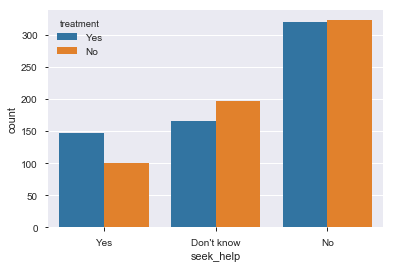

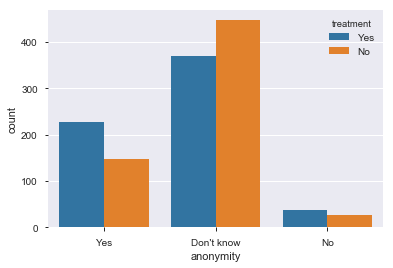

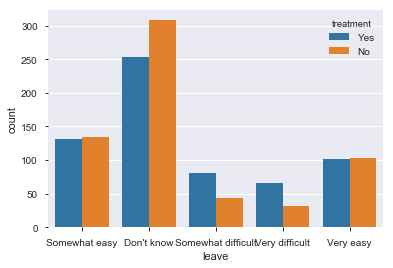

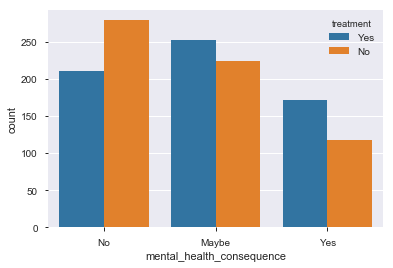

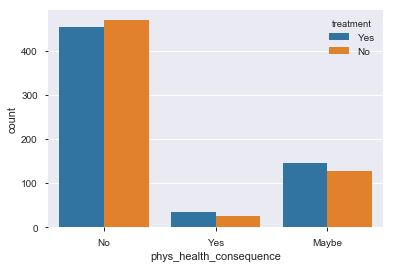

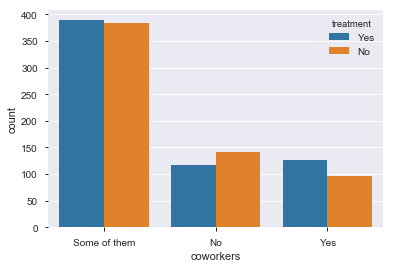

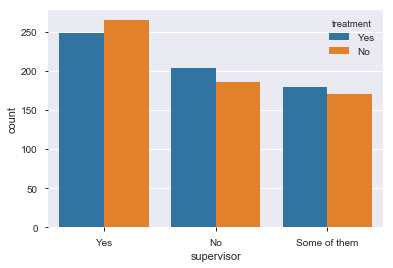

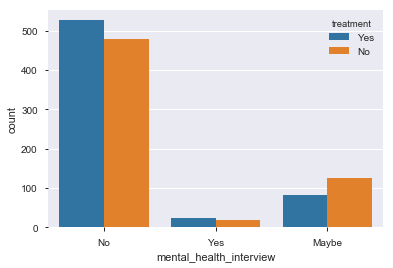

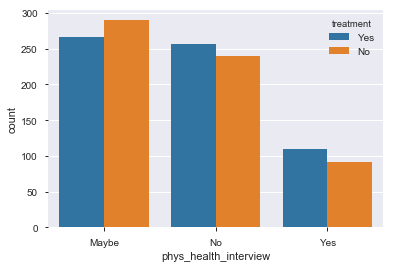

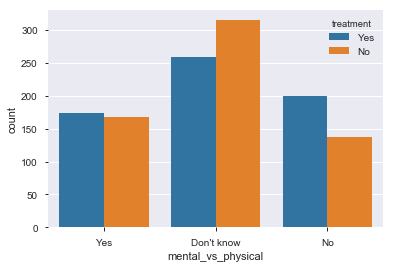

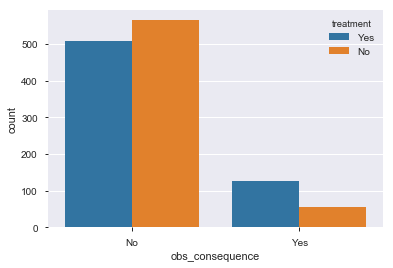

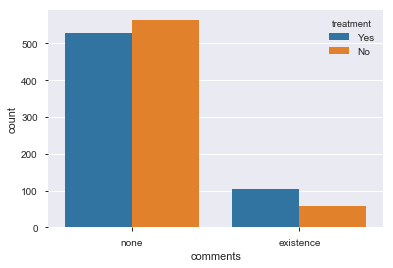

In [11]:
%matplotlib inline
    
for col in df.columns:
#     if col not in check_list:
#         continue
    if col == 'treatment':
        continue
    if col == 'Country' or col == 'state':
        plt.figure(figsize=(7, 20))
        sns.countplot(y=col, hue='treatment', hue_order=df['treatment'].unique(), data=df)
    else:
        if col == 'Age':
            plt.figure(figsize=(20, 7))
        sns.countplot(x=col, hue='treatment', hue_order=df['treatment'].unique(), data=df)
    plt.show()   

## モデル作成準備
### 学習データ設定
ダミー変数化＆訓練/評価データを分割する関数を用意する。  
精度比較のため、"train_test_split"のランダム変数の種を0固定する。

In [12]:
def make_dataset(df_exp, df_res, test_ratio):
    bi_list = []
    for column in df_exp.columns: 
        if df_exp[column].nunique() < 3:
            bi_list.append(column)
    for c in bi_list:
        col = df_exp.columns.tolist()
        col.remove(c)
        col.append(c)
        df_exp_proc = df_exp.ix[:,col]

    df_exp_proc = pd.get_dummies(df_exp_proc)
    df_res_proc = pd.get_dummies(df_res)

    x = df_exp_proc#.as_matrix
    y = df_res_proc['Yes']#.as_matrix
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
#     print(y_test[:10])
    return X_train, X_test, y_train, y_test

### 認識器設定
複数の手法（ロジスティック回帰、ニューラルネットワーク以外）でグリッドサーチを行い、  
その結果得られたAccuracyをスコアとして返す関数を用意する。  
参考のためランダムフォレストの影響度のグラフを出力する。

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras import optimizers

def NN(X_train, X_test, y_train, y_test):
    y_train_ = []
    for tmp in y_train:
        if tmp == 1:
            y_train_.append([0, 1])
        else:
            y_train_.append([1, 0])
    y_train = pd.DataFrame(y_train_)
    y_test_ = []
    for tmp in y_test:
        if tmp == 1:
            y_test_.append([0, 1])
        else:
            y_test_.append([1, 0])
    y_test = pd.DataFrame(y_test_)

    model = Sequential([
        Dense(50, input_shape=(len(X_train.columns),)),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dense(2),
        Activation('softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=50, verbose=0, epochs=100, validation_split=0.1)
    score_train = model.evaluate(X_train, y_train, verbose=1)
    print('Train Accuracy = ', score_train[1])
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Test Accuracy = ', score[1])
    return [score_train[1], score[1]]

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm

def classifiers(X_train, X_test, y_train, y_test, cv_num=5):

    results = {'ロジスティック回帰': [], '決定木': [],  'バギング': [], 
                'ランダムフォレスト': [], 'アダブースト': [], 
                'K近傍法': [], 'SVM': []}


    print('ニューラルネット')
    results['ニューラルネット'] = NN(X_train, X_test, y_train, y_test)
    
    # ロジスティック回帰
    print('ロジスティック回帰')
    clf = lm.LogisticRegression()
    clf.fit (X_train, y_train)
    y_pred_clf = clf.predict(X_test)
    max_acc = 0
    max_thr = 0
    y_test_value = y_test.values
    for i in range(1, 10, 1):
        thr = i * 0.1
        y_pred_clf = clf.predict(X_test)
        y_pred_clf[y_pred_clf < thr] = 0
        y_pred_clf[y_pred_clf >= thr] = 1
        cm = confusion_matrix(y_test_value, y_pred_clf)
        acc = (cm[0][0]+cm[1][1]) / (np.array(cm).sum())
        if acc > max_acc:
            max_acc = acc
            max_thr = i * 0.1
    print('Threshold : ', end='')
    print(max_thr)
    y_pred_clf[y_pred_clf < max_thr] = 0
    y_pred_clf[y_pred_clf >= max_thr] = 1
    y_test_value = y_test.values
    cm_test = confusion_matrix(y_test_value, y_pred_clf)

    y_train_value = y_train.values
    y_pred_clf = clf.predict(X_train)
    y_pred_clf[y_pred_clf < max_thr] = 0
    y_pred_clf[y_pred_clf >= max_thr] = 1
    cm_train = confusion_matrix(y_train_value, y_pred_clf)
    print('Accuracy = ', end='')
    print((cm_test[0][0]+cm_test[1][1]) / (np.array(cm_test).sum()))
    results['ロジスティック回帰'].append((cm_train[0][0]+cm_train[1][1]) / (np.array(cm_train).sum()))
    results['ロジスティック回帰'].append((cm_test[0][0]+cm_test[1][1]) / (np.array(cm_test).sum()))
    print('')
    
    print('決定木')
    tuned_parameters = [{'max_depth':[5,10, 20, 30], 'max_features':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_tree = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_tree.fit(X_train, y_train) 
    result_best = clf_gs_cv_tree.best_params_
    print('Train Accuracy =', clf_gs_cv_tree.best_score_, clf_gs_cv_tree.best_params_)
    predicted_labels = clf_gs_cv_tree.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    print('')
    results['決定木'].append(clf_gs_cv_tree.best_score_)
    results['決定木'].append(score)

    print('バギング')
#     tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'max_features':[0.4, 0.6, 0.8, 1.0], 'max_samples':[0.4, 0.6, 0.8, 1.0]}]
    tuned_parameters = [{'n_estimators':[30, 50, 80, 100], 'max_features':[0.4, 0.6, 1.0], 'max_samples':[0.4, 0.8, 1.0]}]
    clf_gs_cv_bagging = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_bagging.fit(X_train, y_train) 
    result_best = clf_gs_cv_bagging.best_params_
    print('Train Accuracy =', clf_gs_cv_bagging.best_score_, clf_gs_cv_bagging.best_params_)
    predicted_labels = clf_gs_cv_bagging.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['バギング'].append(clf_gs_cv_bagging.best_score_)
    results['バギング'].append(score)
    print('')

    print('ランダムフォレスト')
    tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'max_features':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_rand = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_rand.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_rand.best_score_, clf_gs_cv_rand.best_params_)
    predicted_labels = clf_gs_cv_rand.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['ランダムフォレスト'].append(clf_gs_cv_rand.best_score_)
    results['ランダムフォレスト'].append(score)
    print('')

    print('アダブースト')
    tuned_parameters = [{'n_estimators':[10, 30, 50, 80, 100], 'learning_rate':[0.4, 0.6, 0.8, 1.0]}]
    clf_gs_cv_ada = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm='SAMME.R', random_state=None), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_ada.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_ada.best_score_, clf_gs_cv_ada.best_params_)
    predicted_labels = clf_gs_cv_ada.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['アダブースト'].append(clf_gs_cv_ada.best_score_)
    results['アダブースト'].append(score)
    print('')

    print('K近傍法')
    tuned_parameters = [{'n_neighbors':[1, 3, 5, 8, 10, 12]}]
    clf_gs_cv_kn = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_kn.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_kn.best_score_, clf_gs_cv_kn.best_params_)
    predicted_labels = clf_gs_cv_kn.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['K近傍法'].append(clf_gs_cv_kn.best_score_)
    results['K近傍法'].append(score)
    print('')
    
    print('SVM')
    tuned_parameters = [{'C':[0.4, 0.8, 1.0, 1.2, 1.4, 1.8, 2.0]}]
    clf_gs_cv_svm = GridSearchCV(svm.SVC(), tuned_parameters, cv = cv_num, scoring='accuracy')
    clf_gs_cv_svm.fit(X_train, y_train) 
    print('Train Accuracy =', clf_gs_cv_svm.best_score_, clf_gs_cv_svm.best_params_)
    predicted_labels = clf_gs_cv_svm.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Test Accuracy:', score)
    results['SVM'].append(clf_gs_cv_svm.best_score_)
    results['SVM'].append(score)
    print('')
    
    print('ランダムフォレストにおける各項目の影響度')
    clf_rand = RandomForestClassifier(n_estimators = clf_gs_cv_rand.best_params_['n_estimators'], \
                                      random_state = None, max_features = clf_gs_cv_rand.best_params_['max_features'])
    clf_rand.fit(X_train, y_train)
    predicted_labels = clf_rand.predict(X_test)
    score = accuracy_score(y_test, predicted_labels)
    print('Score: ', score)
    import matplotlib.pyplot as plt
    %matplotlib inline
    features = X_train.columns
    importances = clf_rand.feature_importances_
    indices = np.argsort(importances)
    if len(indices) > 20:
        indices = indices[len(indices)-20:]
    plt.figure(figsize=(6,6))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.show()

    return results

In [27]:
results = OrderedDict()

## 認識器作成

### 元データ

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


ニューラルネット
877/877 [==============================] - 0s 146us/step
Train Accuracy =  0.8084378563963565
377/377 [==============================] - 0s 58us/step
Test Accuracy =  0.7851458882779594
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.8010610079575596

決定木
Train Accuracy = 0.8244013683010262 {'max_features': 1.0, 'max_depth': 5}
Test Accuracy: 0.7745358090185677

バギング
Train Accuracy = 0.8494868871151653 {'n_estimators': 30, 'max_features': 1.0, 'max_samples': 0.4}
Test Accuracy: 0.7931034482758621

ランダムフォレスト
Train Accuracy = 0.8392246294184721 {'n_estimators': 30, 'max_features': 0.4}
Test Accuracy: 0.7877984084880637

アダブースト
Train Accuracy = 0.7708095781071835 {'learning_rate': 0.4, 'n_estimators': 10}
Test Accuracy: 0.7294429708222812

K近傍法
Train Accuracy = 0.6955530216647663 {'n_neighbors': 5}
Test Accuracy: 0.6684350132625995

SVM
Train Accuracy = 0.8403648802736602 {'C': 1.8}
Test Accuracy: 0.7877984084880637

ランダムフォレストにおける各項目の影響度
Score:  0.7851458885941645


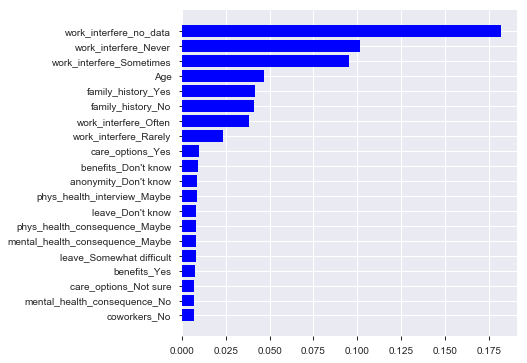

In [28]:
df_exp = df.drop(['treatment'], axis=1)
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['元データ'] = classifiers(X_train, X_test, y_train, y_test, 5)

ランダムフォレストでの影響度を見ると、work_inference、family_history、Ageの有効性が比較的大きいことがわかる。

### ３項目抽出
work_inference、family_history、Ageのみで認識器を作成する。

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


ニューラルネット
877/877 [==============================] - 0s 54us/step
Train Accuracy =  0.8107183581067328
377/377 [==============================] - 0s 46us/step
Test Accuracy =  0.761273207809944
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.7931034482758621

決定木
Train Accuracy = 0.8380843785632839 {'max_features': 0.4, 'max_depth': 5}
Test Accuracy: 0.7931034482758621

バギング
Train Accuracy = 0.8392246294184721 {'n_estimators': 50, 'max_features': 0.6, 'max_samples': 0.4}
Test Accuracy: 0.7904509283819628

ランダムフォレスト
Train Accuracy = 0.8095781071835804 {'n_estimators': 100, 'max_features': 0.6}
Test Accuracy: 0.7798408488063661

アダブースト
Train Accuracy = 0.8084378563283923 {'learning_rate': 0.6, 'n_estimators': 30}
Test Accuracy: 0.7771883289124668

K近傍法
Train Accuracy = 0.7765108323831242 {'n_neighbors': 12}
Test Accuracy: 0.7427055702917772

SVM
Train Accuracy = 0.8380843785632839 {'C': 2.0}
Test Accuracy: 0.7931034482758621

ランダムフォレストにおける各項目の影響度
Score:  0.7771883289124668


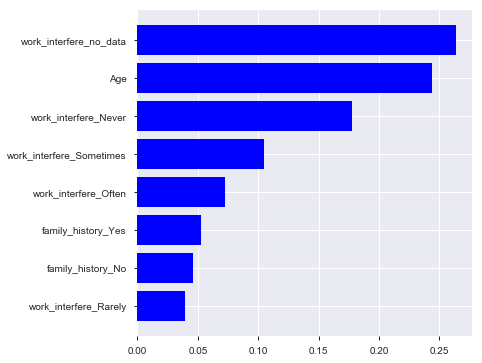

In [29]:
df_exp = df.loc[:,['work_interfere', 'family_history', 'Age']]
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['３項目抽出'] = classifiers(X_train, X_test, y_train, y_test, 5)

ほとんど変わらず。ほかの項目の有無はランダムフォレスト以外の認識器でも影響が小さいということか。

### 従業員数を数値化
今は従業員数がカテゴリ変数になっているが、大小関係や比率が有効かもしれないと考え、数値化した。
数値は1000未満は真ん中の値、1000より多いものは仮に1500とした。

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


ニューラルネット
877/877 [==============================] - 0s 81us/step
Train Accuracy =  0.6054732045126886
377/377 [==============================] - 0s 77us/step
Test Accuracy =  0.5862068970260317
ロジスティック回帰
Threshold : 0.1
Accuracy = 0.8090185676392573

決定木
Train Accuracy = 0.8266818700114025 {'max_features': 0.4, 'max_depth': 5}
Test Accuracy: 0.7771883289124668

バギング
Train Accuracy = 0.8483466362599772 {'n_estimators': 50, 'max_features': 1.0, 'max_samples': 0.4}
Test Accuracy: 0.7904509283819628

ランダムフォレスト
Train Accuracy = 0.8403648802736602 {'n_estimators': 80, 'max_features': 0.8}
Test Accuracy: 0.7877984084880637

アダブースト
Train Accuracy = 0.7605473204104903 {'learning_rate': 0.6, 'n_estimators': 10}
Test Accuracy: 0.7188328912466844

K近傍法
Train Accuracy = 0.645381984036488 {'n_neighbors': 5}
Test Accuracy: 0.6790450928381963

SVM
Train Accuracy = 0.7251995438996579 {'C': 2.0}
Test Accuracy: 0.7347480106100795

ランダムフォレストにおける各項目の影響度
Score:  0.7904509283819628


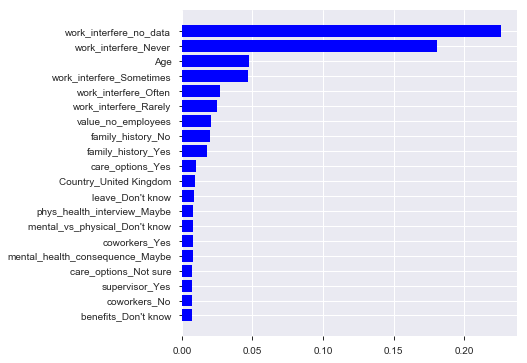

In [30]:
#従業員数を量的データに変換
df_proc = df.copy()
df_proc['value_no_employees'] = 0
df_proc.loc[df_proc['no_employees'] == '1-5', 'value_no_employees'] = 3
df_proc.loc[df_proc['no_employees'] == '6-25', 'value_no_employees'] = 16
df_proc.loc[df_proc['no_employees'] == '26-100', 'value_no_employees'] = 63
df_proc.loc[df_proc['no_employees'] == '100-500', 'value_no_employees'] = 300
df_proc.loc[df_proc['no_employees'] == '500-1000', 'value_no_employees'] = 750
df_proc.loc[df_proc['no_employees'] == 'More than 1000', 'value_no_employees'] = 1500
df_exp = df_proc.drop(['treatment', 'no_employees'], axis=1)
df_res = df_proc['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
results['従業員数を数値化'] = classifiers(X_train, X_test, y_train, y_test, 5)

精度が悪化した。ランダムフォレストの重要度をみると、従業員数が上位に来ているので、影響度は上がったようだが、逆効果か。

## 結果
各データセット、各認識器でのTest Accuracyを下表に示す。

In [31]:
index_ = []
cols = [[],[],[],[],[],[],[],[]]
for key in results.keys():
    index_.append(key)
    for i, method in enumerate(results[key].keys()):
#         print(method)
#         print(results[key][method])
        cols[i].append(results[key][method][1])
df_results = pd.DataFrame({},index=index_)
for i, method in enumerate(results['元データ'].keys()):
    df_results[method] = cols[i]
df_results

,ニューラルネット,ロジスティック回帰,バギング,アダブースト,決定木,ランダムフォレスト,K近傍法,SVM
元データ,0.785146,0.801061,0.793103,0.729443,0.774536,0.787798,0.668435,0.787798
３項目抽出,0.761273,0.793103,0.790451,0.777188,0.793103,0.779841,0.742706,0.793103
従業員数を数値化,0.586207,0.809019,0.790451,0.718833,0.777188,0.787798,0.679045,0.734748


In [33]:
index_ = []
cols = [[],[],[],[],[],[],[],[]]
for key in results.keys():
    index_.append(key)
    for i, method in enumerate(results[key].keys()):
        cols[i].append(results[key][method][0])
df_results = pd.DataFrame({},index=index_)
for i, method in enumerate(results['元データ'].keys()):
    df_results[method] = cols[i]
df_results

,ニューラルネット,ロジスティック回帰,バギング,アダブースト,決定木,ランダムフォレスト,K近傍法,SVM
元データ,0.808438,0.877993,0.849487,0.770810,0.824401,0.839225,0.695553,0.840365
３項目抽出,0.810718,0.846066,0.839225,0.808438,0.838084,0.809578,0.776511,0.838084
従業員数を数値化,0.605473,0.879133,0.848347,0.760547,0.826682,0.840365,0.645382,0.725200


どれも80%弱の精度が出ているが、データセット調整および手法の違いによって精度を向上できなかった。  
特に、ロジスティック回帰が比較的優位な精度を出している点が不可解である。  

### ニューラルネットのパラメータ調べ
NNについてハイパーパラメータを調べていないので、以下手当たり次第に実施する。  
対象データセットは比較的精度は良かった"３項目抽出"を使用する。

#### プロット用関数設定

In [72]:
def plot_history(hist):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc, marker='.', label='train_acc')
    plt.plot(val_acc, marker='.', label='test_acc')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

#### 学習データ整形

In [88]:
df_exp = df.loc[:,['work_interfere', 'family_history', 'Age']]
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
y_train_ = []
for tmp in y_train:
    if tmp == 1:
        y_train_.append([0, 1])
    else:
        y_train_.append([1, 0])
y_train = pd.DataFrame(y_train_)
y_test_ = []
for tmp in y_test:
    if tmp == 1:
        y_test_.append([0, 1])
    else:
        y_test_.append([1, 0])
y_test = pd.DataFrame(y_test_)

Index(['Age', 'work_interfere_Never', 'work_interfere_Often',
       'work_interfere_Rarely', 'work_interfere_Sometimes',
       'work_interfere_no_data', 'family_history_No', 'family_history_Yes'],
      dtype='object')


C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


#### 学習実施

377/377 [==============================] - 0s 56us/step
Test Accuracy =  0.7692307689145642


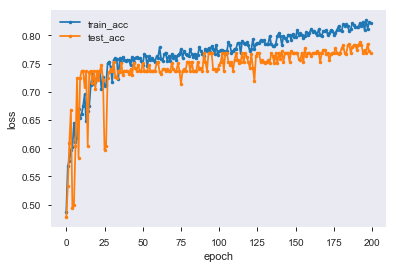

In [75]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=20, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 90us/step
Test Accuracy =  0.7745358087023626


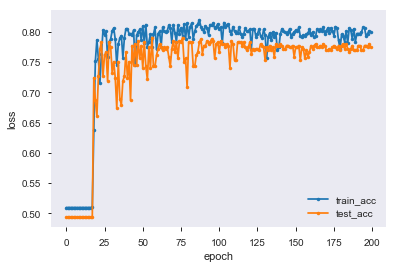

In [76]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, clipnorm=1.), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 253us/step
Test Accuracy =  0.7957559678535563


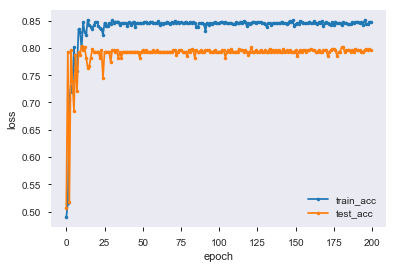

In [80]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 59us/step
Test Accuracy =  0.798408489170378


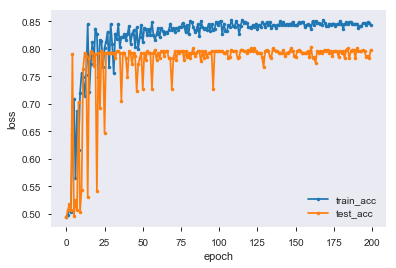

In [79]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 99us/step
Test Accuracy =  0.7957559678535563


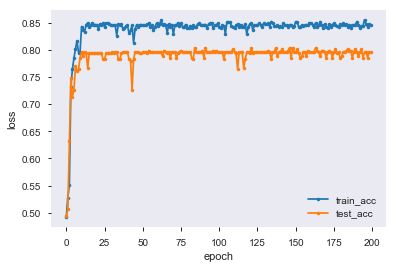

In [77]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 48us/step
Test Accuracy =  0.798408489170378


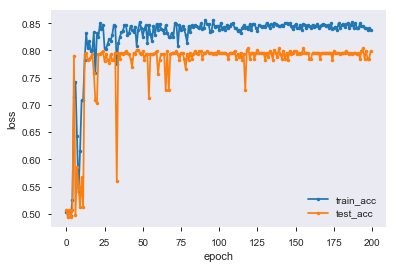

In [78]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

#### 層を深くする

377/377 [==============================] - 0s 71us/step
Test Accuracy =  0.798408489170378


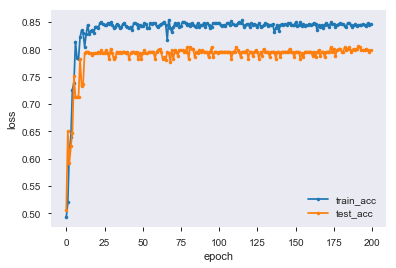

In [84]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

ほとんど効果はみられない。


#### 中間層のノードを増やす

377/377 [==============================] - 0s 93us/step
Test Accuracy =  0.7957559692764788


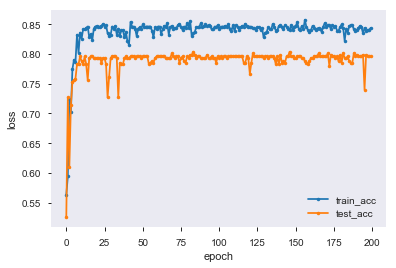

In [86]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(200),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

#### 入力サイズに合わせてノードを削る

377/377 [==============================] - 0s 128us/step
Test Accuracy =  0.7957559678535563


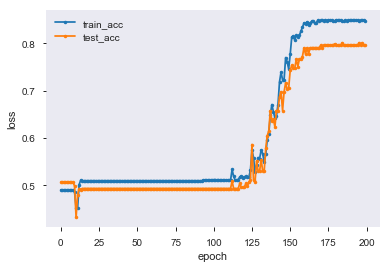

In [91]:
model = Sequential([
    Dense(8, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(5),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

#### 中間層の活性化関数をシグモイドに変更

377/377 [==============================] - 0s 196us/step
Test Accuracy =  0.7533156506578865


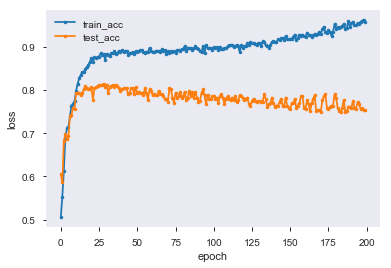

In [100]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('sigmoid'),
    Dense(100),
    Activation('sigmoid'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

#### 全項目を使用

In [92]:
df_exp = df.drop(['treatment'], axis=1)
df_res = df['treatment']
X_train, X_test, y_train, y_test = make_dataset(df_exp, df_res, 0.3)
y_train_ = []
for tmp in y_train:
    if tmp == 1:
        y_train_.append([0, 1])
    else:
        y_train_.append([1, 0])
y_train = pd.DataFrame(y_train_)
y_test_ = []
for tmp in y_test:
    if tmp == 1:
        y_test_.append([0, 1])
    else:
        y_test_.append([1, 0])
y_test = pd.DataFrame(y_test_)

C:\Users\yt5201.ITEC\AppData\Local\Continuum\anaconda3\envs\keras_tf_gpu\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


377/377 [==============================] - 0s 74us/step
Test Accuracy =  0.7480106083404481


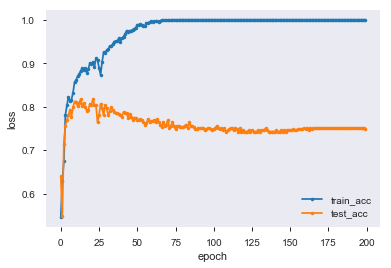

In [93]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 48us/step
Test Accuracy =  0.7798408470672384


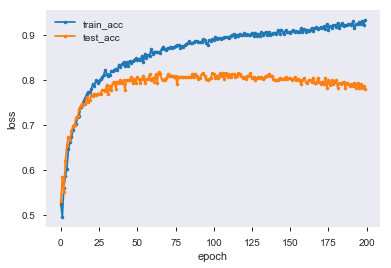

In [94]:
model = Sequential([
    Dense(200, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 233us/step
Test Accuracy =  0.753315649551169


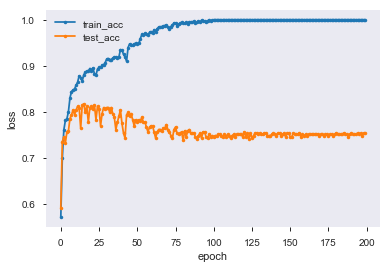

In [96]:
model = Sequential([
    Dense(100, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(50),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 178us/step
Test Accuracy =  0.7745358087023626


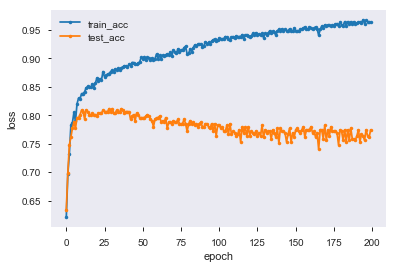

In [98]:
model = Sequential([
    Dense(50, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

377/377 [==============================] - 0s 85us/step
Test Accuracy =  0.7824933694907777


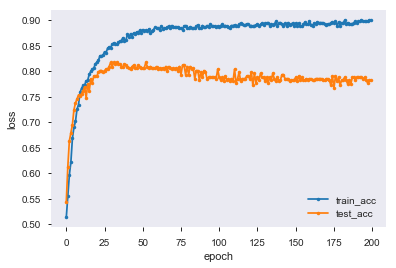

In [102]:
model = Sequential([
    Dense(8, input_shape=(len(X_train.columns),)),
    Activation('relu'),
    Dense(5),
    Activation('relu'),
    Dense(2),
    Activation('softmax')
    ])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])

hist = model.fit(X_train, y_train, batch_size=100, verbose=0, epochs=200, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy = ', score[1])
plot_history(hist)

項目を多くすると、学習率を下げたりNNを小さくしたりしてもオーバーフィッティングしてしまう。